In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore") 

In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

In [3]:
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModel
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, BartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import create_optimizer, AdamWeightDecay
from transformers import pipeline
import datasets
from datasets import Dataset, DatasetDict
#from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from rouge import Rouge

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
df = pd.read_csv("news_summary.csv", encoding="latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
df.describe()

,author,date,headlines,read_more,text,ctext
count,4514,4514,4514,4514,4514,4396
unique,45,240,4514,4461,4514,4341
top,Chhavi Tyagi,"19 Jul 2017,Wednesday",Daman & Diu revokes mandatory Rakshabandhan in...,http://indiatoday.intoday.in/story/assembly-el...,The Administration of Union Territory Daman an...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,559,76,1,13,1,13


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [8]:
df = df[['headlines', 'text', 'ctext']]
df.head()

,headlines,text,ctext
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [9]:
# drop na
df = df.dropna()
df.describe()

,headlines,text,ctext
count,4396,4396,4396
unique,4396,4396,4341
top,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,1,1,13


In [10]:
# Converting to lowercase
df['ctext'] = df['ctext'].apply(str.lower)
df['text'] = df['text'].apply(str.lower)
df['headlines'] = df['headlines'].apply(str.lower)
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [11]:
df['headlines_length'] = [len(x.split()) for x in df.headlines]
df['text_length'] = [len(x.split()) for x in df.text]
df['ctext_length'] = [len(x.split()) for x in df.ctext]
df.head()

,headlines,text,ctext,headlines_length,text_length,ctext_length
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...,9,60,364
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo...",10,60,396
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...,8,60,335
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...,10,60,404
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...,11,60,526


In [12]:
df = df[df['ctext_length'] >= df['text_length']]
df.describe()

,headlines_length,text_length,ctext_length
count,4274.000000,4274.000000,4274.000000
mean,9.300889,58.299719,351.740056
std,1.407168,2.314246,358.884472
min,4.000000,44.000000,50.000000
25%,8.000000,57.000000,193.000000
50%,9.000000,59.000000,288.000000
75%,10.000000,60.000000,416.000000
max,14.000000,62.000000,12202.000000


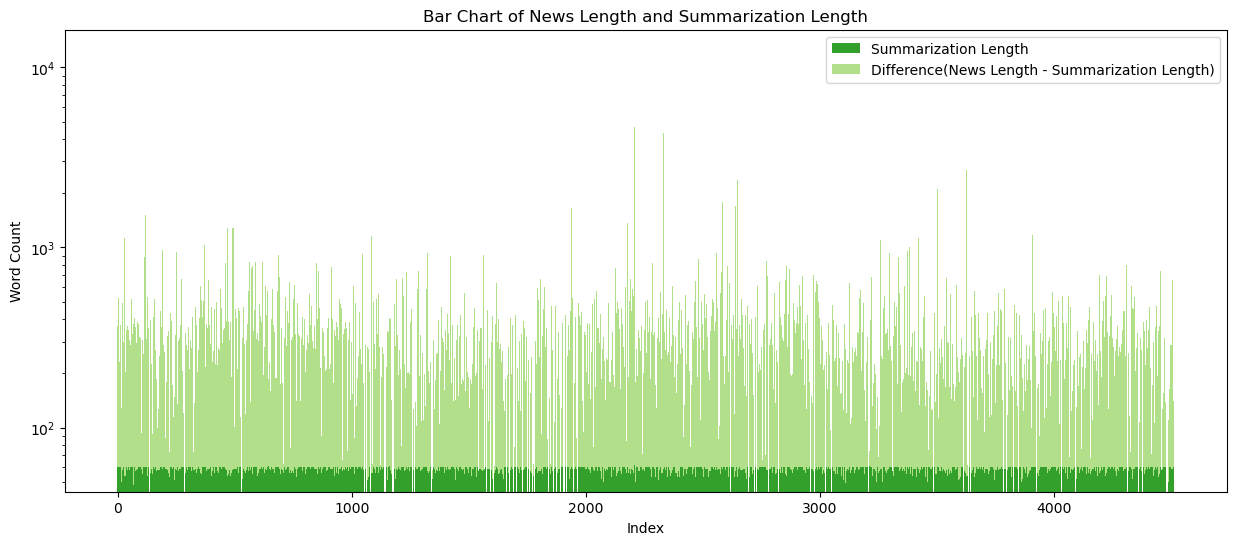

In [13]:
df['diff'] = df['ctext_length'] - df['text_length']
#sns.set(style="whitegrid")
color1 = sns.color_palette("Paired")[3] 
color2 = sns.color_palette("Paired")[2]  

plt.figure(figsize=(15, 6))
bar1 = plt.bar(df.index, df['text_length'], color=color1, label='Summarization Length', width=1.0)
bar2 = plt.bar(df.index, df['diff'], bottom=df['text_length'], color=color2, label='Difference(News Length - Summarization Length)', width=1.0)

plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Bar Chart of News Length and Summarization Length')
plt.legend()
plt.yscale('log')
plt.show()

In [14]:
df = df.drop(columns=['headlines_length', 'text_length', 'ctext_length', 'diff'])
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [15]:
df['news'] = df['headlines'] + '. ' + df['ctext']
df.rename(columns={"text": "summary"}, inplace = True)
df = df.drop(columns=['headlines', 'ctext'])
df.head()

,summary,news
0,the administration of union territory daman an...,daman & diu revokes mandatory rakshabandhan in...
1,malaika arora slammed an instagram user who tr...,malaika slams user who trolled her for 'divorc...
2,the indira gandhi institute of medical science...,'virgin' now corrected to 'unmarried' in igims...
3,lashkar-e-taiba's kashmir commander abu dujana...,aaj aapne pakad liya: let man dujana before be...
4,hotels in maharashtra will train their staff t...,hotel staff to get training to spot signs of s...


In [16]:
# Making the dataset
prefix = 'summarize: '
df['news'] = prefix + df['news']
df.head()

,summary,news
0,the administration of union territory daman an...,summarize: daman & diu revokes mandatory raksh...
1,malaika arora slammed an instagram user who tr...,summarize: malaika slams user who trolled her ...
2,the indira gandhi institute of medical science...,summarize: 'virgin' now corrected to 'unmarrie...
3,lashkar-e-taiba's kashmir commander abu dujana...,summarize: aaj aapne pakad liya: let man dujan...
4,hotels in maharashtra will train their staff t...,summarize: hotel staff to get training to spot...


In [17]:
# Converting the pandas dataset to huggingface dataset
# first split the train and test set
train_df, test_df = train_test_split(df, test_size=0.25, shuffle=True)
print("train and val shape:", train_df.shape, "test shape:",test_df.shape)
# save for every model inference
global_train_df = train_df
global_test_df = test_df
train_df = datasets.Dataset.from_pandas(train_df)
train_df = train_df.remove_columns(["__index_level_0__"])
# split train into train and val
train_df = train_df.train_test_split(test_size=0.2, shuffle=True) # split train and test
train_df["train"][0]

train and val shape: (3205, 2) test shape: (1069, 2)


{'summary': 'television actor parth samthaan was on sunday booked for molestation at a mumbai police station based on a complaint filed by a model. the 20-year-old model had alleged that parth misbehaved with her in a drunken state. she further alleged that he shared her contact number, after which she started receiving calls from boys who wanted "favours" from her.',
 'news': 'summarize: tv actor parth samthaan booked for molestation. tv actor parth samthaan was on sunday booked under section 8 and 12 of posco act in bangur nagar on molestation complaint filed by a model last month. the model had accused samthaan of molestation and registered a complaint at the bangar nagar police station.the victim said she was 16 when she was molested by the actor. samthaan has moved an anticipatory bail application in dindoshi court, which is likely to be heard tomorrow.samthaan was earlier in news after he accused former friend and tv producer vikas gupta of molestation.'}

In [18]:
# Fitting into dataset dict
train_val_test_dataset = DatasetDict({
    'train': train_df["train"],
    'val': train_df['test']})

print(type(train_val_test_dataset))
train_val_test_dataset

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['summary', 'news'],
        num_rows: 2564
    })
    val: Dataset({
        features: ['summary', 'news'],
        num_rows: 641
    })
})

In [19]:
# tokenize the data
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [20]:
def prepare_dataset(data):
    inputs = data["news"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=data["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [21]:
tokenized_data = train_val_test_dataset.map(prepare_dataset, batched=True)

Map:   0%|          | 0/2564 [00:00<?, ? examples/s]

Map:   0%|          | 0/641 [00:00<?, ? examples/s]

In [22]:
tokenized_data["train"]

Dataset({
    features: ['summary', 'news', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2564
})

Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/v4.35.0/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [23]:
# Padding
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = Rouge().get_scores(decoded_preds, decoded_labels, avg=True, ignore_empty=True)

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    # result["gen_len"] = np.mean(prediction_lens)

    return result

### Training

In [25]:
# prepare the model
T5model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [26]:
# set up hyper-parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="t5-news",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

In [27]:
# setup trainer
trainer = Seq2SeqTrainer(
    model = T5model,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [28]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,1.770700,1.625337,"{'r': 0.1422063933231486, 'p': 0.6226265935027524, 'f': 0.22907156930083702}","{'r': 0.06253109345580528, 'p': 0.34072626388630795, 'f': 0.10450387788979448}","{'r': 0.1328369331786073, 'p': 0.5823801602433339, 'f': 0.21404801025724046}"
2,1.682500,1.594156,"{'r': 0.1459451622283829, 'p': 0.6327941644531079, 'f': 0.23458024158398416}","{'r': 0.06567285322555878, 'p': 0.3532055758930129, 'f': 0.10952222115693043}","{'r': 0.13662957990900354, 'p': 0.5933974350316006, 'f': 0.21968402953595506}"
3,1.665000,1.583993,"{'r': 0.14618641009575187, 'p': 0.6358913420707958, 'f': 0.23512908634288954}","{'r': 0.06626530221605713, 'p': 0.35844380821324023, 'f': 0.11061901236044339}","{'r': 0.13643062511567652, 'p': 0.594883460986517, 'f': 0.2195342941845183}"
4,1.657500,1.580746,"{'r': 0.1468923743677981, 'p': 0.6389226559640439, 'f': 0.236284207443439}","{'r': 0.06602478531418453, 'p': 0.35765944566990737, 'f': 0.11024380063778615}","{'r': 0.13697872469341948, 'p': 0.5973270262615954, 'f': 0.22043979522293192}"


Checkpoint destination directory t5-news\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory t5-news\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=5128, training_loss=1.7109682675270879, metrics={'train_runtime': 4124.3232, 'train_samples_per_second': 2.487, 'train_steps_per_second': 1.243, 'total_flos': 1300392577204224.0, 'train_loss': 1.7109682675270879, 'epoch': 4.0})

In [29]:
# save the model
model_path = "t5-news"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('t5-news\\tokenizer_config.json',
 't5-news\\special_tokens_map.json',
 't5-news\\tokenizer.json')

### Summarization

In [30]:
# load the model
model = AutoModelForSeq2SeqLM.from_pretrained("t5-news")

In [33]:
#for i in range(len(test_df['news']):
for i in range(5):
    print("original_news: ",test_df['news'].iloc[i*10])
    summarizer = pipeline("summarization", model = model,tokenizer = tokenizer, max_length = 100)
    summary = summarizer(test_df['news'].iloc[i])
    print(summary[0])
    print()

original_news:  summarize: nestle, reliance milk products contaminated, claims minister. tamil nadu milk and dairy products developments minister rajendra balaji once again stirred a controversy by alleging that the products of private milk producers are adulterated. in a press briefing at his home today, rajendra balaji held two packets of milk products - one by nestle and the other, a product of reliance and affirmed that he had laboratory results which shows they are contaminated.the dairy minister alleged there are contents of caustic soda and bleaching powder in the milk products. balaji was not worried about the health secretary's earlier report to the court claiming that no such adulterants were discovered. he stated that he has with him laboratory results, which prove his claim. "the samples were tested in pune to see if the firms were following the centre's food regulation norms," balaji said.the minister also stated that he came under pressure when he took his stance and he h

{'summary_text': 'election commission-appointed surveillance and expenditure monitoring teams have recovered over ?64 crore in cash, including ?56.04 crore from uttar pradesh alone, and liquor and drugs worth ?8 crore from the five poll-bound states. punjab has witnessed the maximum seizure of drugs worth 1.78 crore (heroine and poppy husk) followed by contraband in goa valued at ? 16.72 lakh while such seizures in'}

original_news:  summarize: farmers oppose land acquisition for proposed noida airport. unhappy with the compensation being offered, farmer leaders of greater noida have decided to start a campaign in jewar?s villages asking other farmers not to give their land for the proposed airport project.their opposition may impact the airport project for which the state government needs 5,000 hectares in around 40 villages along the yamuna expressway. the yamuna expressway industrial development authority (yeida) is likely to begin land acquisition as the centre has given its nod fo

In [34]:
# Free up memory
torch.cuda.empty_cache()